# First Time Window Start

## 1. Dataset Generation and Pre-processing

In [1]:
!export PYSPARK_PYTHON=python3.6.9
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout,Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
import subprocess
import tensorflow as tf
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.corpus import brown
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.streaming.kafka import KafkaUtils
import pyspark.sql.functions as f
import json
import re
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
import sys
from pyspark.sql.types import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import from_json
from pyspark.sql.functions import lit
import pickle
import tensorflow.keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import zeros
from keras.models import model_from_json
from tensorflow import keras
from pyspark.sql.functions import udf
import pandas as pd

spark.sparkContext.getConf().getAll()

Using TensorFlow backend.


[('spark.eventLog.enabled', 'true'),
 ('spark.executor.instances', '3'),
 ('spark.sql.execution.arrow.enabled', 'true'),
 ('spark.app.id', 'application_1643192276452_0159'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.cores', '5'),
 ('spark.executor.extraJavaOptions', '-XX:+UseG1GC'),
 ('spark.driver.extraJavaOptions', '-XX:+UseG1GC'),
 ('spark.driver.host', 'kafka1'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.yarn.archive', 'hdfs:///user/spark/conf/spark-libs.jar'),
 ('spark.driver.port', '46825'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.sql.shuffle.partitions', '200'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.kryoserializer.buffer.max', '2047'),
 ('spark.executor.memoryOverhead', '1g'),
 ('spark.driver.memoryOverhead', '1g'),
 ('spark.ui.proxyBase', '/proxy/application_1643192276452_0159'),
 ('spark.executor.memory', '4g'),
 ('spark

In [2]:
# 임시코드
csi_pos_neg = spark.read.csv("hdfs:///user/spark/datafile/csiposneg.csv", header=True)
csi_pos_neg = csi_pos_neg.withColumn("label",col("label").cast("integer"))
csi_pos_neg = csi_pos_neg.drop(col('_c0'))

In [3]:
pred_test3 = pd.read_json("/root/spark/SecurityNews.json")
pred_test3 = spark.createDataFrame(pred_test3[['text']])

/root/spark/python/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  An error occurred while calling z:org.apache.spark.sql.api.python.PythonSQLUtils.readArrowStreamFromFile.
: java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.readNextBatch(ArrowConverters.scala:243)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.<init>(ArrowConverters.scala:229)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$.getBatchesFromStream(ArrowConverters.scala:228)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anonfun$readArrowStreamFromFile$2.apply(ArrowConverters.scala:216)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anonfun

In [4]:
pred_test3 = pred_test3.withColumn('label', lit(1))

In [5]:
# #러시아
# russia = spark.read.csv("hdfs:///user/spark/datafile/StreamingAPI_russia.csv", header=True)

In [6]:
# russia = russia.withColumn("label", lit(1).cast("integer"))
# russia = russia.drop(col('_c0'))
# russia = russia.drop(col('timestamp'))
# russia = russia.drop(col('numberOftweet'))
# russia = russia.drop(col('total_id_list'))
# russia = russia.withColumnRenamed("total_text_list", "text")

In [7]:
f = open('/root/keywordset.txt', 'r', encoding='utf-8')
keyfile = f.readline()
keyword_list = list()
keywords = keyfile.split(',')
for keyword in keywords:
    keyword_list.append(keyword.strip())

In [8]:
t1 = csi_pos_neg.collect()[:89756]
t2 = csi_pos_neg.collect()[89756:99756]
t3 = csi_pos_neg.collect()[99756:189512]
t4 = csi_pos_neg.collect()[189512:199512]

k1 = pred_test3.collect()[:99756]
k2 = pred_test3.collect()[99756:109756]

In [9]:
t1 = spark.createDataFrame(t1)
t2 = spark.createDataFrame(t2)
t3 = spark.createDataFrame(t3)
t4 = spark.createDataFrame(t4)

k1 = spark.createDataFrame(k1)
k2 = spark.createDataFrame(k2)

first_df = k1.union(t3)
first_df_df = t1.union(t3) #.union(t3).union(t7) # 179512 

second_df = k2.union(t4) # 20000 -> unrevealed data for all periods
second_df_df = t2.union(t4)

In [10]:
# first = first_df_df.toPandas().dropna(axis=0)
# first_df_df = spark.createDataFrame(first)

# second = second_df.toPandas().dropna(axis=0)
# second_df = spark.createDataFrame(second)

In [11]:
# 개수 확인
first_df.count(), first_df_df.count(), second_df.count()

(189512, 179512, 20000)

In [12]:
# get_tokens 함수과 같은 용도
stage_1 = RegexTokenizer(inputCol= 'text', outputCol='pos_t', pattern= '\\W')
# get_lemma 함수와 같은 용도
stage_2 = StopWordsRemover(inputCol= stage_1.getOutputCol(), outputCol= 'filtered_words')

mid_pipeline = Pipeline(stages=[stage_1, stage_2])
mid_preprocessing = mid_pipeline.fit(first_df)
mid_preprocessed = mid_preprocessing.transform(first_df)

## 2. W2V embedding with pre-trained glove vector

In [13]:
class vocabulary:
    staticList = list()
    
class label:
    staticList = list()

In [14]:
from gensim.test.utils import datapath
from gensim.test.utils import get_tmpfile, common_dictionary, common_corpus
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# load the vectors. other vector sizes were used but yielded generally less sensible models
glove_file = datapath("/root/spark/glove.6B.100d.txt")
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

In [15]:
from gensim.utils import simple_preprocess
import pandas as pd

vocabulary.staticList = [' '.join(sample) for sample in mid_preprocessed.select("filtered_words").rdd.flatMap(lambda x: x).collect()]
label.staticList = mid_preprocessed.select("label").rdd.flatMap(lambda x: x).collect()

df = pd.DataFrame(zip(vocabulary.staticList, label.staticList), columns = ['sentence_str', 'label'])
# using gensim's built-in tokenizer 
df['gensim_tokenized'] = df['sentence_str'].map(lambda x: simple_preprocess(x.lower(),deacc=True, max_len=100))

In [16]:
# for this to work, your input is going to be a list of tokenized sentences
# since my data was in a dataframe, first I selected the appropriate series
documents = df[df['label'] == 1]['gensim_tokenized']
print(len(documents))
# then made it into a list
sentences = [sentence for sentence in documents]

from sklearn.feature_extraction import _stop_words
stopwords = list(_stop_words.ENGLISH_STOP_WORDS)

cleaned_sentences = []
for sentence in sentences:
    cleaned = [word.lower() for word in sentence]
    cleaned = [word for word in cleaned if word not in stopwords]
    cleaned_sentences.append(cleaned)

99756


In [17]:
whataboutthis = mid_preprocessed.filter(col('label')==1).select("filtered_words").rdd.flatMap(lambda x: x).collect()

In [18]:
np.array(whataboutthis).shape

(99756,)

In [19]:
np.array(cleaned_sentences).shape

(99756,)

In [20]:
from gensim.models.word2vec import Word2Vec

# build a word2vec model on your dataset
base_model = Word2Vec(size=100, min_count=3)
base_model.build_vocab(whataboutthis) # update를 통해 나중에 업데이트를 하면될듯.
total_examples = base_model.corpus_count

In [21]:
# add GloVe's vocabulary & weights
base_model.build_vocab([list(glove_vectors.vocab.keys())], update=True) # second time window에서 update시 어떻게 동작하는지 확인

# train on your data
base_model.train(whataboutthis, total_examples=total_examples, epochs=base_model.iter) #최적의 eppoch를 찾자
base_model_wv = base_model.wv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [22]:
glove_vectors['exploit'], base_model_wv['exploit']

(array([-0.098216 ,  0.20087  , -0.038727 ,  0.31802  ,  0.053134 ,
        -0.72742  , -0.83355  , -0.67791  ,  0.52024  , -0.042178 ,
        -0.20028  ,  0.18313  , -0.14683  , -0.82972  , -0.098902 ,
        -0.066934 ,  0.48781  ,  0.2925   , -0.59683  , -0.037449 ,
         0.061095 , -0.47391  ,  0.54906  ,  0.0071644, -0.43423  ,
        -0.46022  , -0.016787 ,  0.22323  ,  0.19409  , -0.049059 ,
        -0.034777 ,  0.59895  , -0.2767   , -0.41311  ,  0.41968  ,
        -0.56002  , -0.3903   , -0.22804  , -0.18673  ,  0.082971 ,
        -0.089508 ,  0.10001  , -0.41983  , -0.2799   , -0.42178  ,
         0.24893  ,  0.55424  ,  0.14925  , -0.25707  , -0.09267  ,
        -0.66923  ,  0.94212  , -0.038461 ,  0.91143  ,  0.44912  ,
        -0.90749  ,  0.2815   , -0.65291  ,  0.67227  , -0.89961  ,
        -0.7966   ,  0.080673 , -0.10182  , -0.058376 ,  0.91208  ,
        -0.061385 ,  0.96656  , -0.47821  ,  0.049519 , -0.49825  ,
         0.65407  , -0.26749  , -0.43593  , -0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


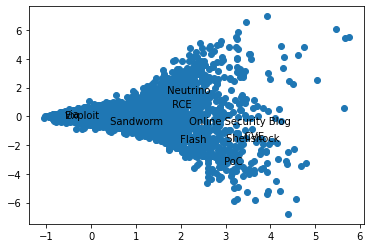

In [23]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = base_model[base_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = keywords[:10] #list(base_model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [24]:
base_model.save('/root/spark/model_2')

In [25]:
base_model_wv.save_word2vec_format('/root/spark/w2v_for_nn.bin')
base_model_wv.save('/root/spark/w2v_for_nn.wordvectors')

## 3. TextVectorization

In [26]:
class voc:
    staticList = list() # 현재는 계속해서 incremental하게 사이즈가 커지고 있다

class word_index:
    staticDict = dict() # 현재는 계속해서 incremental하게 사이즈가 커지고 있다
    
class x_train:
    data = None

In [27]:
class a:
    length = len(voc.staticList) # 현재는 계속해서 incremental하게 사이즈가 커지고 있다

class b:
    length = len(word_index.staticDict) # 현재는 계속해서 incremental하게 사이즈가 커지고 있다

In [28]:
nb_words = len(base_model.wv.vocab.keys())
print(nb_words)

15389


In [29]:
samples = [' '.join(sample) for sample in mid_preprocessed.select("filtered_words").rdd.flatMap(lambda x: x).collect()]

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(whataboutthis)
train_sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(train_sequences, maxlen=200, padding='post')

In [31]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(label.staticList)

In [32]:
consider_num = 10000

# from keras.layers import Embedding

word_index = tokenizer.word_index
i = 0

embedding_matrix = np.zeros((consider_num, 100))
for word, i in word_index.items():
    if i == consider_num:
        break
        
    if word in base_model_wv.vocab:
        embedding_matrix[i] = base_model_wv.word_vec(word)
    i = i + 1

print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)

Null word embeddings: 1


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [34]:
first_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=first_optimizer,metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 193, 32)           25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 96, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 89, 32)            8224      
_________________________________________________________________
flatten (Flatten)            (None, 2848)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               284900    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, shuffle=True)

In [36]:
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=6, batch_size=512)

print(hist.history['loss'])
print(hist.history['acc'])
print(hist.history['val_loss'])
print(hist.history['val_acc'])

Epoch 1/6
278/278 [==============================] - 29s 103ms/step - loss: 0.2295 - acc: 0.9086 - val_loss: 0.1705 - val_acc: 0.9386
Epoch 2/6
278/278 [==============================] - 29s 103ms/step - loss: 0.1612 - acc: 0.9422 - val_loss: 0.1653 - val_acc: 0.9414
Epoch 3/6
278/278 [==============================] - 28s 103ms/step - loss: 0.1477 - acc: 0.9474 - val_loss: 0.1476 - val_acc: 0.9472
Epoch 4/6
278/278 [==============================] - 28s 102ms/step - loss: 0.1376 - acc: 0.9508 - val_loss: 0.1439 - val_acc: 0.9485
Epoch 5/6
278/278 [==============================] - 29s 103ms/step - loss: 0.1313 - acc: 0.9528 - val_loss: 0.1427 - val_acc: 0.9493
Epoch 6/6
278/278 [==============================] - 29s 103ms/step - loss: 0.1256 - acc: 0.9548 - val_loss: 0.1376 - val_acc: 0.9508
[0.2295144498348236, 0.16116149723529816, 0.14773599803447723, 0.1375814527273178, 0.13131189346313477, 0.12560339272022247]
[0.9086003303527832, 0.9421954154968262, 0.9474369287490845, 0.95077884

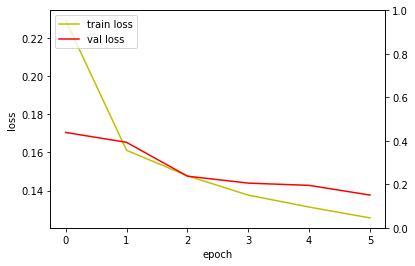

In [37]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

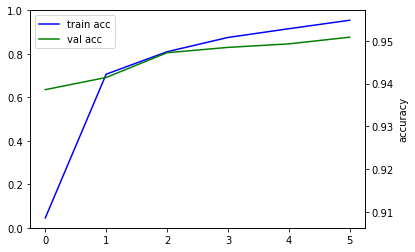

In [38]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [39]:
mid_preprocessing_test = mid_pipeline.fit(second_df)
mid_preprocessed_test = mid_preprocessing_test.transform(second_df)
test_samples = [' '.join(sample) for sample in mid_preprocessed_test.select("filtered_words").rdd.flatMap(lambda x: x).collect()]
test_sequences = tokenizer.texts_to_sequences(test_samples)
x_test = pad_sequences(test_sequences, maxlen=200, padding='post')

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(mid_preprocessed_test.select("label").rdd.flatMap(lambda x: x).collect())

In [40]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1720452457666397
Test accuracy: 0.9370999932289124


In [41]:
mid_preprocessing_test = mid_pipeline.fit(second_df_df)
mid_preprocessed_test = mid_preprocessing_test.transform(second_df_df)
test_samples = [' '.join(sample) for sample in mid_preprocessed_test.select("filtered_words").rdd.flatMap(lambda x: x).collect()]
test_sequences = tokenizer.texts_to_sequences(test_samples)
x_test = pad_sequences(test_sequences, maxlen=200, padding='post')

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(mid_preprocessed_test.select("label").rdd.flatMap(lambda x: x).collect())

In [42]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4568864703178406
Test accuracy: 0.8299499750137329


In [43]:
model.save("model_1_ckpt")
model.save_weights("pretrained_1_ckpt")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_1_ckpt/assets


# Second Time Window Start

In [ ]:
def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    """Converts a text to a sequence of words (or tokens).
    # Arguments
        text: Input text (string).
        filters: list (or concatenation) of characters to filter out, such as
            punctuation. Default: ``!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\\t\\n``,
            includes basic punctuation, tabs, and newlines.
        lower: boolean. Whether to convert the input to lowercase.
        split: str. Separator for word splitting.
    # Returns
        A list of words (or tokens).
    """
    if lower:
        text = text.lower()

    if sys.version_info < (3,):
        if isinstance(text, unicode):  # noqa: F821
            translate_map = {
                ord(c): unicode(split) for c in filters  # noqa: F821
            }
            text = text.translate(translate_map)
        elif len(split) == 1:
            translate_map = maketrans(filters, split * len(filters))
            text = text.translate(translate_map)
        else:
            for c in filters:
                text = text.replace(c, split)
    else:
        translate_dict = {c: split for c in filters}
        translate_map = maketrans(translate_dict)
        text = text.translate(translate_map)

    seq = text.split(split)
    return [i for i in seq if i]


def one_hot(text, n,
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True,
            split=' '):
    """One-hot encodes a text into a list of word indexes of size n.
    This is a wrapper to the `hashing_trick` function using `hash` as the
    hashing function; unicity of word to index mapping non-guaranteed.
    # Arguments
        text: Input text (string).
        n: int. Size of vocabulary.
        filters: list (or concatenation) of characters to filter out, such as
            punctuation. Default: ``!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\\t\\n``,
            includes basic punctuation, tabs, and newlines.
        lower: boolean. Whether to set the text to lowercase.
        split: str. Separator for word splitting.
    # Returns
        List of integers in [1, n]. Each integer encodes a word
        (unicity non-guaranteed).
    """
    return hashing_trick(text, n,
                         hash_function=hash,
                         filters=filters,
                         lower=lower,
                         split=split)


def hashing_trick(text, n,
                  hash_function=None,
                  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                  lower=True,
                  split=' '):
    """Converts a text to a sequence of indexes in a fixed-size hashing space.
    # Arguments
        text: Input text (string).
        n: Dimension of the hashing space.
        hash_function: defaults to python `hash` function, can be 'md5' or
            any function that takes in input a string and returns a int.
            Note that 'hash' is not a stable hashing function, so
            it is not consistent across different runs, while 'md5'
            is a stable hashing function.
        filters: list (or concatenation) of characters to filter out, such as
            punctuation. Default: ``!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\\t\\n``,
            includes basic punctuation, tabs, and newlines.
        lower: boolean. Whether to set the text to lowercase.
        split: str. Separator for word splitting.
    # Returns
        A list of integer word indices (unicity non-guaranteed).
    `0` is a reserved index that won't be assigned to any word.
    Two or more words may be assigned to the same index, due to possible
    collisions by the hashing function.
    The [probability](
        https://en.wikipedia.org/wiki/Birthday_problem#Probability_table)
    of a collision is in relation to the dimension of the hashing space and
    the number of distinct objects.
    """
    if hash_function is None:
        hash_function = hash
    elif hash_function == 'md5':
        def hash_function(w):
            return int(md5(w.encode()).hexdigest(), 16)

    seq = text_to_word_sequence(text,
                                filters=filters,
                                lower=lower,
                                split=split)
    return [(hash_function(w) % (n - 1) + 1) for w in seq]


In [ ]:
import string
import sys
import warnings
from collections import OrderedDict
from collections import defaultdict
from hashlib import md5
import json

import numpy as np
from six.moves import range
from six.moves import zip

if sys.version_info < (3,):
    maketrans = string.maketrans
else:
    maketrans = str.maketrans
    
class Tokenizer(object):
    """Text tokenization utility class.
    This class allows to vectorize a text corpus, by turning each
    text into either a sequence of integers (each integer being the index
    of a token in a dictionary) or into a vector where the coefficient
    for each token could be binary, based on word count, based on tf-idf...
    # Arguments
        num_words: the maximum number of words to keep, based
            on word frequency. Only the most common `num_words-1` words will
            be kept.
        filters: a string where each element is a character that will be
            filtered from the texts. The default is all punctuation, plus
            tabs and line breaks, minus the `'` character.
        lower: boolean. Whether to convert the texts to lowercase.
        split: str. Separator for word splitting.
        char_level: if True, every character will be treated as a token.
        oov_token: if given, it will be added to word_index and used to
            replace out-of-vocabulary words during text_to_sequence calls
    By default, all punctuation is removed, turning the texts into
    space-separated sequences of words
    (words maybe include the `'` character). These sequences are then
    split into lists of tokens. They will then be indexed or vectorized.
    `0` is a reserved index that won't be assigned to any word.
    """

    def __init__(self, num_words=None,
                 previous_document_count=None,
                 previous_word_counts=None,
                 previous_word_docs=None,
                 previous_index_docs=None,
                 vocabulary=None,
                 now_count=0,
                 pword_index=None,
                 filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                 lower=True,
                 split=' ',
                 char_level=False,
                 oov_token=None,
                 document_count=0,
                 **kwargs):
        # Legacy support
        if 'nb_words' in kwargs:
            warnings.warn('The `nb_words` argument in `Tokenizer` '
                          'has been renamed `num_words`.')
            num_words = kwargs.pop('nb_words')
        if kwargs:
            raise TypeError('Unrecognized keyword arguments: ' + str(kwargs))
        self.previous_document_count = previous_document_count
        self.previous_word_counts = previous_word_counts
        self.previous_word_docs = previous_word_docs
        self.previous_index_docs = previous_index_docs
        self.word_counts = OrderedDict()
        self.word_docs = defaultdict(int)
        self.filters = filters
        self.split = split
        self.lower = lower
        self.num_words = num_words
        self.vocabulary = vocabulary
        self.document_count = document_count
        self.char_level = char_level
        self.oov_token = oov_token
        self.index_docs = defaultdict(int)
        self.word_index = {}
        self.now_count = now_count
        self.pword_index = pword_index
        self.index_word = {}

    def fit_on_texts(self, texts):
        """Updates internal vocabulary based on a list of texts.
        In the case where texts contains lists,
        we assume each entry of the lists to be a token.
        Required before using `texts_to_sequences` or `texts_to_matrix`.
        # Arguments
            texts: can be a list of strings,
                a generator of strings (for memory-efficiency),
                or a list of list of strings.
        """
        for text in texts:
            self.document_count += 1
            if self.char_level or isinstance(text, list): # true
                if self.lower: # true
                    if isinstance(text, list): # true
                        text = [text_elem.lower() for text_elem in text]
                    else:
                        text = text.lower()
                seq = text
            else:
                seq = text_to_word_sequence(text,
                                            self.filters,
                                            self.lower,
                                            self.split)
            for w in seq:
                if w in self.previous_word_counts: # 첫번째 time window에 대한 word_counts정보 유지해야할듯
                    self.previous_word_counts[w] += 1 # orderedDict의 형태
                else:
                    self.previous_word_counts[w] = 1 # 처음으로 등장한 단어는 사전에 추가
            for w in set(seq):
                # In how many documents each word occurs
                self.previous_word_docs[w] += 1 # 하나의 문장에 두번 등장하더라도 한번으로 카운트

        wcounts = list(self.previous_word_counts.items())
        wcounts.sort(key=lambda x: x[1], reverse=True)
        
        # forcing the oov_token to index 1 if it exists
        if self.oov_token is None:
            sorted_voc = []
        else:
            sorted_voc = [self.oov_token]
        # list의 원소를 sorted_voc에 넣는다
        sorted_voc.extend(wc[0] for wc in wcounts)

        # note that index 0 is reserved, never assigned to an existing word
        # word_index와 index_word는 시간에 따라 변화하므로 previous time window 정보 필요 x
        self.word_index = dict(
            zip(sorted_voc, list(range(1, len(sorted_voc) + 1))))

        self.index_word = {c: w for w, c in self.word_index.items()}

        for w, c in list(self.previous_word_docs.items()):
            self.index_docs[self.word_index[w]] = c

    def fit_on_sequences(self, sequences):
        """Updates internal vocabulary based on a list of sequences.
        Required before using `sequences_to_matrix`
        (if `fit_on_texts` was never called).
        # Arguments
            sequences: A list of sequence.
                A "sequence" is a list of integer word indices.
        """
        self.document_count += len(sequences)
        for seq in sequences:
            seq = set(seq)
            for i in seq:
                self.index_docs[i] += 1

    def texts_to_sequences(self, texts):
        """Transforms each text in texts to a sequence of integers.
        Only top `num_words-1` most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            texts: A list of texts (strings).
        # Returns
            A list of sequences.
        """
        return list(self.texts_to_sequences_generator(texts))

    def texts_to_sequences_generator(self, texts):
        """Transforms each text in `texts` to a sequence of integers.
        Each item in texts can also be a list,
        in which case we assume each item of that list to be a token.
        Only top `num_words-1` most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            texts: A list of texts (strings).
        # Yields
            Yields individual sequences.
        """
        num_words = self.num_words
        oov_token_index = self.word_index.get(self.oov_token)
        for text in texts:
            if self.char_level or isinstance(text, list): # true
                if self.lower: # true
                    if isinstance(text, list): # true
                        text = [text_elem.lower() for text_elem in text]
                    else:
                        text = text.lower()
                seq = text
            else:
                seq = text_to_word_sequence(text,
                                            self.filters,
                                            self.lower,
                                            self.split)
            vect = []
            for w in seq:
                i = self.word_index.get(w)
                if i is not None:
                    if num_words and i >= num_words:
                        if oov_token_index is not None:
                            vect.append(oov_token_index)
                    else:
                        vect.append(i)
                elif self.oov_token is not None:
                    vect.append(oov_token_index)
            yield vect

    def sequences_to_texts(self, sequences):
        """Transforms each sequence into a list of text.
        Only top `num_words-1` most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            sequences: A list of sequences (list of integers).
        # Returns
            A list of texts (strings)
        """
        return list(self.sequences_to_texts_generator(sequences))

    def sequences_to_texts_generator(self, sequences):
        """Transforms each sequence in `sequences` to a list of texts(strings).
        Each sequence has to a list of integers.
        In other words, sequences should be a list of sequences
        Only top `num_words-1` most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            sequences: A list of sequences.
        # Yields
            Yields individual texts.
        """
        num_words = self.num_words
        oov_token_index = self.word_index.get(self.oov_token)
        for seq in sequences:
            vect = []
            for num in seq:
                word = self.index_word.get(num)
                if word is not None:
                    if num_words and num >= num_words:
                        if oov_token_index is not None:
                            vect.append(self.index_word[oov_token_index])
                    else:
                        vect.append(word)
                elif self.oov_token is not None:
                    vect.append(self.index_word[oov_token_index])
            vect = ' '.join(vect)
            yield vect

    def texts_to_matrix(self, texts, mode='binary'):
        """Convert a list of texts to a Numpy matrix.
        # Arguments
            texts: list of strings.
            mode: one of "binary", "count", "tfidf", "freq".
        # Returns
            A Numpy matrix.
        """
        sequences = self.texts_to_sequences(texts)
        return self.sequences_to_matrix(sequences, mode=mode)

    def sequences_to_matrix(self, sequences, mode='binary'):
        """Converts a list of sequences into a Numpy matrix.
        # Arguments
            sequences: list of sequences
                (a sequence is a list of integer word indices).
            mode: one of "binary", "count", "tfidf", "freq"
        # Returns
            A Numpy matrix.
        # Raises
            ValueError: In case of invalid `mode` argument,
                or if the Tokenizer requires to be fit to sample data.
        """
        if not self.num_words:
            if self.word_index:
                num_words = len(self.word_index) + 1
            else:
                raise ValueError('Specify a dimension (`num_words` argument), '
                                 'or fit on some text data first.')
        else:
            num_words = self.num_words

        if mode == 'tfidf' and not self.document_count:
            raise ValueError('Fit the Tokenizer on some data '
                             'before using tfidf mode.')

        x = np.zeros((len(sequences), num_words))
        for i, seq in enumerate(sequences):
            if not seq:
                continue
            counts = defaultdict(int)
            for j in seq:
                if j >= num_words:
                    continue
                counts[j] += 1
            for j, c in list(counts.items()):
                if mode == 'count':
                    x[i][j] = c
                elif mode == 'freq':
                    x[i][j] = c / len(seq)
                elif mode == 'binary':
                    x[i][j] = 1
                elif mode == 'tfidf':
                    # Use weighting scheme 2 in
                    # https://en.wikipedia.org/wiki/Tf%E2%80%93idf
                    tf = 1 + np.log(c)
                    idf = np.log(1 + self.document_count /
                                 (1 + self.index_docs.get(j, 0)))
                    x[i][j] = tf * idf
                else:
                    raise ValueError('Unknown vectorization mode:', mode)
        return x

    def get_config(self):
        '''Returns the tokenizer configuration as Python dictionary.
        The word count dictionaries used by the tokenizer get serialized
        into plain JSON, so that the configuration can be read by other
        projects.
        # Returns
            A Python dictionary with the tokenizer configuration.
        '''
        json_word_counts = json.dumps(self.word_counts)
        json_word_docs = json.dumps(self.word_docs)
        json_index_docs = json.dumps(self.index_docs)
        json_word_index = json.dumps(self.word_index)
        json_index_word = json.dumps(self.index_word)

        return {
            'num_words': self.num_words,
            'filters': self.filters,
            'lower': self.lower,
            'split': self.split,
            'char_level': self.char_level,
            'oov_token': self.oov_token,
            'document_count': self.document_count,
            'word_counts': json_word_counts,
            'word_docs': json_word_docs,
            'index_docs': json_index_docs,
            'index_word': json_index_word,
            'word_index': json_word_index
        }

    def to_json(self, **kwargs):
        """Returns a JSON string containing the tokenizer configuration.
        To load a tokenizer from a JSON string, use
        `keras.preprocessing.text.tokenizer_from_json(json_string)`.
        # Arguments
            **kwargs: Additional keyword arguments
                to be passed to `json.dumps()`.
        # Returns
            A JSON string containing the tokenizer configuration.
        """
        config = self.get_config()
        tokenizer_config = {
            'class_name': self.__class__.__name__,
            'config': config
        }
        return json.dumps(tokenizer_config, **kwargs)


def tokenizer_from_json(json_string):
    """Parses a JSON tokenizer configuration file and returns a
    tokenizer instance.
    # Arguments
        json_string: JSON string encoding a tokenizer configuration.
    # Returns
        A Keras Tokenizer instance
    """
    tokenizer_config = json.loads(json_string)
    config = tokenizer_config.get('config')

    word_counts = json.loads(config.pop('word_counts'))
    word_docs = json.loads(config.pop('word_docs'))
    index_docs = json.loads(config.pop('index_docs'))
    # Integer indexing gets converted to strings with json.dumps()
    index_docs = {int(k): v for k, v in index_docs.items()}
    index_word = json.loads(config.pop('index_word'))
    index_word = {int(k): v for k, v in index_word.items()}
    word_index = json.loads(config.pop('word_index'))

    tokenizer = Tokenizer(**config)
    tokenizer.word_counts = word_counts
    tokenizer.word_docs = word_docs
    tokenizer.index_docs = index_docs
    tokenizer.word_index = word_index
    tokenizer.index_word = index_word

    return tokenizer

## 1. W2V update

In [44]:
mid_preprocessing2 = mid_pipeline.fit(first_df_df)
mid_preprocessed2 = mid_preprocessing.transform(first_df_df)

In [45]:
class vocabulary:
    staticList = list()

class label:
    staticList = list()

In [45]:
from gensim.models import KeyedVectors
glove_vectors = KeyedVectors.load('/root/spark/w2v_for_nn.wordvectors')

In [46]:
from gensim.utils import simple_preprocess
import pandas as pd

vocabulary.staticList = [' '.join(sample) for sample in mid_preprocessed2.select("filtered_words").rdd.flatMap(lambda x: x).collect()]
label.staticList = mid_preprocessed2.select("label").rdd.flatMap(lambda x: x).collect()

df = pd.DataFrame(zip(vocabulary.staticList, label.staticList), columns = ['sentence_str', 'label'])
# using gensim's built-in tokenizer 
df['gensim_tokenized'] = df['sentence_str'].map(lambda x: simple_preprocess(x.lower(),deacc=True, max_len=100))

In [47]:
# for this to work, your input is going to be a list of tokenized sentences
# since my data was in a dataframe, first I selected the appropriate series
documents = df[df['label'] == 1]['gensim_tokenized']
print(len(documents))
# then made it into a list
sentences = [sentence for sentence in documents]

from sklearn.feature_extraction import _stop_words
stopwords = list(_stop_words.ENGLISH_STOP_WORDS)

cleaned_sentences2 = []
for sentence in sentences:
    cleaned = [word.lower() for word in sentence]
    cleaned = [word for word in cleaned if word not in stopwords]
    cleaned_sentences2.append(cleaned)

89756


In [48]:
whataboutthis2 = mid_preprocessed2.filter(col('label')==1).select("filtered_words").rdd.flatMap(lambda x: x).collect()

In [49]:
samples2 = [' '.join(sample) for sample in mid_preprocessed2.select("filtered_words").rdd.flatMap(lambda x: x).collect()]

In [50]:
np.array(whataboutthis2).shape, np.array(cleaned_sentences2).shape

((89756,), (89756,))

In [ ]:
glove_vectors['exploit']

In [52]:
# whataboutthis2 = np.concatenate((whataboutthis2, np.array(keywords)), axis=0)

In [53]:
from gensim.models.word2vec import Word2Vec

# build a word2vec model on your dataset
base_model = Word2Vec(size=100, min_count=3)
base_model.build_vocab(whataboutthis2) # update를 통해 나중에 업데이트를 하면될듯.
#total_examples = base_model.corpus_count
total_examples=base_model.corpus_count

In [54]:
base_model_wv['exploit']

array([ 5.88739872e-01, -1.65753853e+00,  1.63240874e+00, -6.09797776e-01,
       -4.77880418e-01,  1.22978143e-01, -7.21395612e-01,  1.23376954e+00,
       -9.13401067e-01, -1.04990840e+00,  1.87458789e+00, -1.24846129e-02,
       -1.97980762e-01, -1.90585241e-01,  3.19648594e-01, -1.63873643e-01,
        8.89792919e-01, -4.21326131e-01, -1.73105806e-01,  1.28869340e-01,
       -2.03979611e+00, -8.37180972e-01,  2.52652109e-01, -3.24494153e-01,
       -1.78078085e-01, -1.46861696e+00, -2.47751921e-01,  4.36765462e-01,
       -4.53474233e-03,  1.37667055e-03,  3.44098568e-01, -7.86076784e-01,
       -2.54062355e-01, -8.40891063e-01, -3.69752437e-01,  1.47991469e-02,
       -6.13933980e-01,  3.89817178e-01, -6.14674687e-01, -7.49643207e-01,
       -2.62645911e-02,  5.71172059e-01,  3.16446930e-01, -3.03669244e-01,
        4.94935036e-01, -7.54575312e-01,  5.28732121e-01,  9.20529068e-01,
       -3.20852160e-01, -3.12829405e-01, -7.65342116e-01, -2.41868999e-02,
        1.83833674e-01, -

In [55]:
len(list(base_model.wv.vocab))

22903

# Keyword in/out 알고리즘 구현
-> build_vocab(update=True, trim_rule='별도 선언 필요')

trim_rule should be passed to model.build_vocab() NOT during model initialization

In [56]:
exclude_set_v = [] # 제외할 단어 'rt'이런것들

import gensim
def my_rule(word, count, min_count):
    return gensim.utils.RULE_KEEP

In [57]:
exclude_set_v = [] # 제외할 단어 'rt'이런것들

def trim_rule(word, count, min_count):
    """Exist in the randomly sampled exclude_set, then DISCARD"""
    if word in exclude_set_v: #== "impressed":  # keep entity token
        return gensim.utils.RULE_DISCARD
    else:
        return gensim.utils.RULE_KEEP

In [58]:
# add GloVe's vocabulary & weights
base_model.build_vocab([list(glove_vectors.vocab.keys())], update=True, trim_rule=my_rule) # second time window에서 update시 어떻게 동작하는지 확인
# base_model.intersect_word2vec_format('/root/spark/w2v_for_nn.bin', binary=True)
# start_alpha=0.001, end_alpha=0.00001

# train on your data
base_model.train(whataboutthis2, total_examples=total_examples, epochs=base_model.iter) #최적의 eppoch를 찾자
base_model_wv = base_model.wv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


In [60]:
base_model_wv['exploit']

array([ 0.67505175,  0.81083345,  0.11056683,  0.59151286,  1.6262561 ,
       -0.49840474, -0.96398866, -0.24518147,  1.3147537 ,  0.48856884,
       -0.4826721 ,  0.64064956, -1.0676185 ,  1.0281329 , -0.72985774,
       -0.28893435,  0.54994845, -1.5724381 , -1.205162  ,  1.1544223 ,
        0.06164861, -0.09766277, -0.4047545 , -0.07298576,  0.48262635,
       -0.04834059,  0.15622027,  0.68809134, -0.12680757,  1.9712049 ,
        0.5276265 , -1.8127208 ,  0.00983357,  1.7922226 , -1.894384  ,
       -2.0101924 , -1.5335528 , -0.2982737 , -1.4549634 ,  0.40241894,
        0.8830866 , -1.5051447 , -0.98802584, -0.16670893,  0.7494549 ,
       -0.9591115 , -0.11748961, -0.45607856,  0.1684627 , -0.5269329 ,
        0.7473638 , -1.5408885 , -0.20686549, -1.0175078 , -0.05794153,
        0.924876  ,  0.68545264,  3.0220172 ,  1.9200997 , -1.2589574 ,
       -0.58768654, -0.6101911 ,  1.3252015 , -1.0190983 ,  2.4443176 ,
       -1.0739274 , -3.3025804 ,  1.6876395 , -0.49770454,  0.85

In [61]:
len(list(base_model.wv.vocab))

28764

In [ ]:
prioritiezed dataset을 유지해서 재 학습 하는 방식으로 바꾸자.
이렇게 했을때 기존 keyword의 weight값이 변하는 지 확인
새로운 keyword와 일관성 때문에 낮은 정확도 도출되는것으로 확인됨

keyword 제거 rule 선언하지 않았을때

In [62]:
print('처음개수 :',len(set(list(glove_vectors.vocab.keys()))),'둘째개수 :', len(set(list(base_model.wv.vocab.keys()))))

same = len(set(list(glove_vectors.vocab.keys())) & set(list(base_model.wv.vocab.keys())))
print('둘 사이에 겹치는 keyword :', same)

first = len(set(list(glove_vectors.vocab.keys())) - set(list(base_model.wv.vocab.keys())))
print('사라진 keyword :', first)

second = len(set(list(base_model.wv.vocab.keys())) - set(list(glove_vectors.vocab.keys())))
print('새로 생긴 keyword :', second)

처음개수 : 15389 둘째개수 : 28764
둘 사이에 겹치는 keyword : 15389
사라진 keyword : 0
새로 생긴 keyword : 13375


In [63]:
base_model_wv.save_word2vec_format('/root/spark/w2v_for_nn2.bin')
base_model_wv.save('/root/spark/w2v_for_nn2.wordvectors')

기존의 text.Tokenizer 라이브러리 customize

In [64]:
document_count = tokenizer.document_count
word_counts = tokenizer.word_counts
word_docs = tokenizer.word_docs
index_docs = tokenizer.index_docs

In [65]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer2 = Tokenizer(num_words=10000, previous_document_count=document_count, \
                       previous_word_counts=word_counts, previous_word_docs=word_docs, \
                       previous_index_docs=index_docs, vocabulary=exclude_set_v, \
                       pword_index=tokenizer.word_counts, now_count = 8204) 
# 여기에 추가로 포함되는 1173개가 이전 텍스트에서 frequency가 높은 corpus가 아님

tokenizer2.fit_on_texts(whataboutthis2)
train_sequences = tokenizer2.texts_to_sequences(samples2)

In [66]:
important = list(set(list(tokenizer.word_index.keys())[:10]+list(tokenizer2.word_index.keys())[:10]))

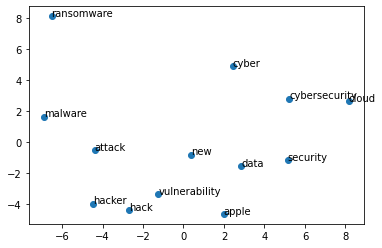

In [67]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = glove_vectors[important]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = important#list(base_model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


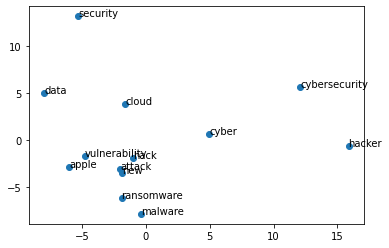

In [68]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = base_model[important]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = important #list(base_model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [87]:
tokenizer.word_index

{'security': 1,
 'data': 2,
 'cloud': 3,
 'new': 4,
 'cyber': 5,
 'malware': 6,
 'attack': 7,
 'apple': 8,
 'ransomware': 9,
 'hack': 10,
 'crypto': 11,
 'breach': 12,
 'market': 13,
 'hacker': 14,
 'vulnerability': 15,
 'blockchain': 16,
 'google': 17,
 'android': 18,
 'network': 19,
 'u': 20,
 'cybersecurity': 21,
 'user': 22,
 'threat': 23,
 'hacked': 24,
 'business': 25,
 'service': 26,
 'million': 27,
 'report': 28,
 'say': 29,
 'mobile': 30,
 'window': 31,
 'privacy': 32,
 'microsoft': 33,
 'update': 34,
 'facebook': 35,
 'iot': 36,
 'system': 37,
 'app': 38,
 'iphone': 39,
 'secure': 40,
 'device': 41,
 'internet': 42,
 'troj': 43,
 'risk': 44,
 'global': 45,
 'cve': 46,
 'company': 47,
 'get': 48,
 'phishing': 49,
 'apps': 50,
 'web': 51,
 'release': 52,
 'top': 53,
 'launch': 54,
 'account': 55,
 'software': 56,
 'hacking': 57,
 'hit': 58,
 'application': 59,
 'na': 60,
 'customer': 61,
 'tech': 62,
 'phone': 63,
 'file': 64,
 'flaw': 65,
 'email': 66,
 'website': 67,
 'online

In [88]:
tokenizer2.word_index

{'security': 1,
 'cybersecurity': 2,
 'data': 3,
 'hacker': 4,
 'new': 5,
 'malware': 6,
 'cyber': 7,
 'vulnerability': 8,
 'cloud': 9,
 'attack': 10,
 'cve': 11,
 'apple': 12,
 'ransomware': 13,
 'hacking': 14,
 'hack': 15,
 'breach': 16,
 'google': 17,
 'android': 18,
 'bitcoin': 19,
 'crypto': 20,
 'network': 21,
 'market': 22,
 'microsoft': 23,
 'service': 24,
 'rt': 25,
 'securityaffairs': 26,
 'threat': 27,
 'hacked': 28,
 'blockchain': 29,
 'web': 30,
 'business': 31,
 'user': 32,
 'internet': 33,
 'update': 34,
 'mobile': 35,
 'news': 36,
 'report': 37,
 'million': 38,
 'infosec': 39,
 'remote': 40,
 'privacy': 41,
 'u': 42,
 'facebook': 43,
 'code': 44,
 'system': 45,
 'get': 46,
 'iphone': 47,
 'say': 48,
 'app': 49,
 'via': 50,
 'information': 51,
 'us': 52,
 'iot': 53,
 'software': 54,
 'secure': 55,
 'online': 56,
 'risk': 57,
 'windows': 58,
 'top': 59,
 'phishing': 60,
 'file': 61,
 'exploit': 62,
 'global': 63,
 'cybercrime': 64,
 'using': 65,
 'world': 66,
 'window': 6

In [79]:
# # # # 첫번째 tokenizer의 활용
# train_sequences = tokenizer.texts_to_sequences(samples2)

In [52]:
x_train = pad_sequences(train_sequences, maxlen=200, padding='post')

In [53]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(label.staticList)

In [54]:
x_train

array([[  24,  997, 4024, ...,    0,    0,    0],
       [ 115,   18,    6, ...,    0,    0,    0],
       [ 522,  928,   85, ...,    0,    0,    0],
       ...,
       [ 486,  526, 1166, ...,    0,    0,    0],
       [6180,  912, 8736, ...,    0,    0,    0],
       [4978, 3062,  502, ...,    0,    0,    0]], dtype=int32)

In [56]:
# from keras.layers import Embedding
word_index2 = tokenizer2.word_index

In [57]:
consider_num2 = 10000

embedding_matrix2 = np.zeros((consider_num2, 100))

i = 0
for word, i in word_index2.items():
    if i == consider_num2:
        break
        
    if word in base_model_wv.vocab:
        embedding_matrix2[i] = base_model_wv.word_vec(word)
    else:
        print(word)
    i = i + 1
    
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix2, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix2.shape[0], # or len(word_index) + 1
                            embedding_matrix2.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix2],
                            input_length=200,
                            trainable=False)

Null word embeddings: 1


In [74]:
# embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
#                             embedding_matrix.shape[1], # or EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=200,
#                             trainable=False)

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D

model2 = Sequential()
model2.add(embedding_layer)
model2.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dense(2, activation='softmax'))

In [79]:
pretrained_model = tf.keras.models.load_model("model_1_ckpt")
weights_list = pretrained_model.get_weights()

In [80]:
for i, layer in enumerate(model2.layers):
    print(i,'\t',layer.trainable,'\t  :',layer.name)

0 	 False 	  : embedding_1
1 	 True 	  : conv1d_4
2 	 True 	  : max_pooling1d_2
3 	 True 	  : conv1d_5
4 	 True 	  : flatten_2
5 	 True 	  : dense_4
6 	 True 	  : dense_5


In [81]:
for i, layer in enumerate(pretrained_model.layers):
    print(i,'\t',layer.trainable,'\t  :',layer.name)

0 	 True 	  : embedding
1 	 True 	  : conv1d
2 	 True 	  : max_pooling1d
3 	 True 	  : conv1d_1
4 	 True 	  : flatten
5 	 True 	  : dense
6 	 True 	  : dense_1


In [82]:
for i in range(len(model2.get_weights())):
    print(model2.get_weights()[i].shape)

(10000, 100)
(8, 100, 32)
(32,)
(8, 32, 32)
(32,)
(2848, 100)
(100,)
(100, 2)
(2,)


In [83]:
for i in range(len(weights_list)):
    print(weights_list[i].shape)

(10000, 100)
(8, 100, 32)
(32,)
(8, 32, 32)
(32,)
(2848, 100)
(100,)
(100, 2)
(2,)


In [84]:
for i, layer in enumerate(model2.layers):
    if layer.trainable_weights:
        print(layer.name, weights_list[i].shape, model2.layers[i].name, model2.get_weights()[i].shape)
        layer.set_weights(pretrained_model.layers[i].get_weights())

conv1d_4 (8, 100, 32) conv1d_4 (8, 100, 32)
conv1d_5 (8, 32, 32) conv1d_5 (8, 32, 32)
dense_4 (2848, 100) dense_4 (2848, 100)
dense_5 (100,) dense_5 (100,)


In [85]:
# model2.layers[0].set_weights([embedding_matrix2])
# model2.layers[0].trainable = False
# print(model2.layers[0].name)

In [86]:
# Check that all of the pretrained weights have been loaded.
for a, b in zip(model2.weights, pretrained_model.weights):
    try:
        np.testing.assert_allclose(a.numpy(), b.numpy())
        print("성공!!!!!!!!!!!!!!!")
    except Exception as e:
        print('예외가 발생했습니다.', e)

성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!
성공!!!!!!!!!!!!!!!


In [87]:
# print('model를 동결하기 전 훈련되는 가중치의 수:',
#      len(model.trainable_weights))
print('model를 동결하기 전 훈련되는 가중치의 수:',
     len(model2.trainable_weights))

for layer in model2.layers[:2]: 
    layer.trainable = False
    
# print('model를 동결한 후 훈련되는 가중치의 수:',
#      len(model.trainable_weights))
print('model를 동결한 후 훈련되는 가중치의 수:',
     len(model2.trainable_weights))

model를 동결하기 전 훈련되는 가중치의 수: 8
model를 동결한 후 훈련되는 가중치의 수: 6


In [88]:
for i, layer in enumerate(model2.layers):
    print(i,'\t',layer.trainable,'\t  :',layer.name)

0 	 False 	  : embedding_1
1 	 False 	  : conv1d_4
2 	 True 	  : max_pooling1d_2
3 	 True 	  : conv1d_5
4 	 True 	  : flatten_2
5 	 True 	  : dense_4
6 	 True 	  : dense_5


In [89]:
from sklearn.model_selection import train_test_split
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train, y_train, test_size=0.25, shuffle=True)

In [90]:
second_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=second_optimizer, metrics=['acc'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 193, 32)           25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 96, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 89, 32)            8224      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2848)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               284900    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [91]:
hist2 = model2.fit(x_train2, y_train2, validation_data=(x_valid2, y_valid2), epochs=6, batch_size=256) #128

Epoch 1/6
263/263 [==============================] - 12s 44ms/step - loss: 0.3247 - acc: 0.8583 - val_loss: 0.3199 - val_acc: 0.8601
Epoch 2/6
263/263 [==============================] - 11s 44ms/step - loss: 0.3144 - acc: 0.8621 - val_loss: 0.3149 - val_acc: 0.8627
Epoch 3/6
263/263 [==============================] - 11s 43ms/step - loss: 0.3100 - acc: 0.8635 - val_loss: 0.3156 - val_acc: 0.8624
Epoch 4/6
263/263 [==============================] - 11s 44ms/step - loss: 0.3067 - acc: 0.8655 - val_loss: 0.3137 - val_acc: 0.8640
Epoch 5/6
263/263 [==============================] - 11s 44ms/step - loss: 0.3040 - acc: 0.8661 - val_loss: 0.3109 - val_acc: 0.8648
Epoch 6/6
263/263 [==============================] - 11s 43ms/step - loss: 0.3015 - acc: 0.8671 - val_loss: 0.3106 - val_acc: 0.8649


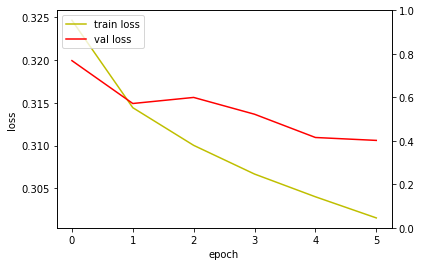

In [92]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist2.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

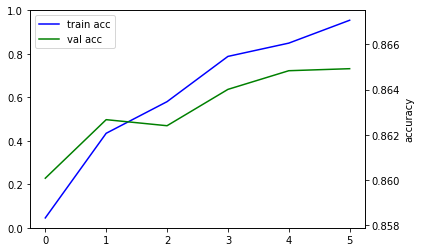

In [93]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
acc_ax.plot(hist2.history['acc'], 'b', label='train acc')
acc_ax.plot(hist2.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [94]:
mid_preprocessing_test = mid_pipeline.fit(second_df)
mid_preprocessed_test = mid_preprocessing_test.transform(second_df)
test_samples = [' '.join(sample) for sample in mid_preprocessed_test.select("filtered_words").rdd.flatMap(lambda x: x).collect()]
test_sequences = tokenizer2.texts_to_sequences(test_samples)
x_test = pad_sequences(test_sequences, maxlen=200, padding='post')

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(mid_preprocessed_test.select("label").rdd.flatMap(lambda x: x).collect())

NameError: name 'tokenizer2' is not defined

In [ ]:
score = model2.evaluate(x_test, y_test, verbose=0) # 89% 이상
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # lr=0.001 -> 0.84

In [ ]:
mid_preprocessing_test = mid_pipeline.fit(second_df_df)
mid_preprocessed_test = mid_preprocessing_test.transform(second_df_df)
test_samples = [' '.join(sample) for sample in mid_preprocessed_test.select("filtered_words").rdd.flatMap(lambda x: x).collect()]
test_sequences = tokenizer2.texts_to_sequences(test_samples)
x_test = pad_sequences(test_sequences, maxlen=200, padding='post')

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(mid_preprocessed_test.select("label").rdd.flatMap(lambda x: x).collect())

In [ ]:
score = model2.evaluate(x_test, y_test, verbose=0) # 89% 이상
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # lr=0.001 -> 0.84

In [97]:
model2.save("model_2_ckpt")
model2.save_weights("pretrained_2_ckpt")

INFO:tensorflow:Assets written to: model_2_ckpt/assets


In [198]:
## embedding layer의 크기는 큰 영향이 없는것으로 보인다.

In [ ]:
from pyspark.ml import Transformer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from typing import Dict
from pyspark.sql import DataFrame
from tensorflow.keras.preprocessing import sequence

class TextToSequence(Transformer):
    #vectorizer = TextVectorization(output_sequence_length=200, vocabulary=list(base_model.wv.vocab.keys()))#max_tokens=20000, 
    tokenizer = Tokenizer(num_words=nb_words)
    
    def __init__(self):
        super(TextToSequence, self).__init__()
        
    def _transform(self, df: DataFrame):
        # 우리가 해야할 일은 dataframe을 순서통일해서 text와 label 리스트로 나누는것
        samples = [' '.join(sample) for sample in df.select("filtered_words").rdd.flatMap(lambda x: x).collect()]
        labels = df.select("label").rdd.flatMap(lambda x: x).collect()
        
        # train_x = [' '.join(sample) for sample in df.filter(col('label')==1).select("filtered_words").rdd.flatMap(lambda x: x).collect()]
        
        self.tokenizer.fit_on_texts(cleaned_sentences)
        train_sequences = self.tokenizer.texts_to_sequences(samples)
        x_train.data = sequence.pad_sequences(train_sequences, maxlen=200, padding='post')
        
        words = df.select("filtered_words").rdd.flatMap(lambda x: x).collect()
        # 200의 길이로 상위 2만개의 토큰만 반영
#         text_ds = tf.data.Dataset.from_tensor_slices(samples).batch(128)
#         self.vectorizer.adapt(text_ds)
        
        temp = voc.staticList
        print(len(temp))
        # 엄데이트 하는 식으로 구현 동작 바꾸기!
        voc.staticList = self.vectorizer.get_vocabulary() #list(set(voc.staticList + self.vectorizer.get_vocabulary()))
        
        aa = self.vectorizer.get_vocabulary()# list(set(self.vectorizer.get_vocabulary())-set(temp))
        print(len(aa),"!")
        
        post_length = len(voc.staticList)
        word_index.staticDict.update(dict(zip(aa, range(a.length, a.length+len(aa)))))
        
        #x_train.data = self.vectorizer(np.array([[s] for s in samples])).numpy()
        zip_array = list(zip(samples, labels, x_train.data.tolist()))
        rdd = sc.parallelize(zip_array, 306) #, numSlices=306
        fdf = rdd.toDF(['text','label','feature'])
        
        return fdf